In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_ml_est = os.path.join(cwd, '..', 'tools', 'ml_estimation')
api_path_data = os.path.join(api_path_ml_est, 'data', "sonar.all-data.csv")

sys.path.append(api_path)
sys.path.append(api_path_ml_est)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch, torch.nn as nn
from functools import partial

from sir_ais_sampling import (sir_correlated_dynamics,
                              sir_independent_dynamics)

from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal)

from ebm_sampling import (MH_Transition, grad_energy, 
                          ais_dynamics, ais_vanilla_dynamics)

In [4]:
df = pd.read_csv(api_path_data, header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [35]:
inputs_df = df.drop(60, axis=1)
inputs_df['60'] = np.ones(inputs_df.shape[0])
targets_df = pd.get_dummies(df[60], dtype = np.int32)
inputs_df = torch.FloatTensor(inputs_df.to_numpy())
mine_y_df = torch.FloatTensor((targets_df['M'] * 2 - 1).to_numpy())


X_train, X_test, y_train, y_test = train_test_split(inputs_df, 
                                                    mine_y_df, 
                                                    test_size=0.30, 
                                                    random_state=42)
X_train_small = X_train[:, :-1]
X_test_small = X_test[:, :-1]

In [36]:
# normalization

mean = X_train_small.mean(0)
X_train_small = X_train_small - mean[None, :]
X_test_small = X_test_small - mean[None, :]
Sigma = 1/(X_train_small.shape[0] - 1) * X_train_small.T @ X_train_small
u, s, v = torch.svd(Sigma)
inv_Sigma = v @ torch.diag(s**(-1)) @ u.T
X_train_small = X_train_small @ inv_Sigma
X_test_small = X_test_small @ inv_Sigma

X_train = torch.cat([X_train_small, torch.ones(X_train_small.shape[0]).unsqueeze(-1)], -1)
X_test = torch.cat([X_test_small, torch.ones(X_test_small.shape[0]).unsqueeze(-1)], -1)

In [37]:
import scipy
from scipy.special import expit
from scipy.special import logsumexp

class BinaryLogisticLoss():
    def __init__(self, l2_coef):
        """
        Parameters
        ----------
        l2_coef - l2 regularization coefficient
        """
        self.l2_coef = l2_coef
        
    
    def func(self, w, X, y):
        """
        Get loss function value for data X, target y and coefficient w.

        Parameters
        ----------
        X : scipy.sparse.csr_matrix or numpy.ndarray
        y : 1d numpy.ndarray
        w : 1d numpy.ndarray

        Returns
        -------
        : float
        """
        exp_part = y[:, None] * (X @ w.T)
        batch_sigmoid = torch.logaddexp(torch.zeros_like(exp_part), -exp_part) #np.logaddexp(0., -exp_part) 
        return batch_sigmoid.sum(axis = 0) + self.l2_coef*(torch.norm(w[:, :-1], dim = 1)**2)
    
    def log_prob_args(self, w, X, y):
        return -self.func(w, X, y)
    
def calculate_losses(history, loss_fun, X_train, X_test, y_train, y_test):
    loss_train = []
    loss_test = []
    for _, w in enumerate(history):
        train_loss = loss_fun(w, X_train, y_train).item()
        test_loss = loss_fun(w, X_test, y_test).item()

        loss_train.append(train_loss)
        loss_test.append(test_loss)

        print('Iter: %d, Training loss: %f, Test loss %f' % (_,
                                                             loss_train[-1], 
                                                             loss_test[-1]))
    return loss_train, loss_test

In [38]:
from sklearn.linear_model import LogisticRegression
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train, y_train).item()
    test_loss_clf = target.func(w_clf, X_test, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

max_iter = 1, train_loss = 98.31674194335938, test_loss = 52.18492889404297
max_iter = 2, train_loss = 97.22148132324219, test_loss = 53.89168930053711
max_iter = 3, train_loss = 95.53587341308594, test_loss = 56.150115966796875
max_iter = 4, train_loss = 94.13980865478516, test_loss = 59.76487350463867
max_iter = 5, train_loss = 92.92514038085938, test_loss = 58.46730041503906
max_iter = 6, train_loss = 91.28996276855469, test_loss = 56.03534698486328
max_iter = 7, train_loss = 90.2677001953125, test_loss = 56.457576751708984
max_iter = 8, train_loss = 89.03186798095703, test_loss = 55.725399017333984
max_iter = 9, train_loss = 87.65279388427734, test_loss = 56.919586181640625
max_iter = 10, train_loss = 86.727783203125, test_loss = 56.00035095214844
max_iter = 11, train_loss = 85.35400390625, test_loss = 52.73145294189453
max_iter = 12, train_loss = 84.35968780517578, test_loss = 50.84765625
max_iter = 13, train_loss = 83.85661315917969, test_loss = 46.50453567504883
max_iter = 14, t

In [39]:
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.9310344827586207
0.746031746031746


In [40]:
dim = X_train.shape[1]
zeros_start = torch.zeros((1, dim))
train_loss = target.func(zeros_start, X_train, y_train).item()
test_loss = target.func(zeros_start, X_test, y_test).item()
print(train_loss, test_loss)

100.50631713867188 43.66825485229492


# SIR 

In [41]:
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
proposal = init_independent_normal(scale_proposal, dim, device)

n_steps = 10000
#batch_size = 32
c = 0.01
N = 20
alpha = (1 - c/dim)**0.5
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
#start = proposal.sample([batch_size])
#start = torch.zeros((1, dim))
start = proposal.sample([1]) #w_clf
history = sir_correlated_dynamics(start, 
                                  target,
                                  proposal, 
                                  n_steps, 
                                  N, 
                                  alpha)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

ter: 9659, Training loss: 98.467018, Test loss 78.860786
Iter: 9660, Training loss: 98.467018, Test loss 78.860786
Iter: 9661, Training loss: 98.467018, Test loss 78.860786
Iter: 9662, Training loss: 98.467018, Test loss 78.860786
Iter: 9663, Training loss: 94.607300, Test loss 78.789742
Iter: 9664, Training loss: 94.607300, Test loss 78.789742
Iter: 9665, Training loss: 94.607300, Test loss 78.789742
Iter: 9666, Training loss: 94.607300, Test loss 78.789742
Iter: 9667, Training loss: 94.607300, Test loss 78.789742
Iter: 9668, Training loss: 94.607300, Test loss 78.789742
Iter: 9669, Training loss: 94.607300, Test loss 78.789742
Iter: 9670, Training loss: 94.607300, Test loss 78.789742
Iter: 9671, Training loss: 94.607300, Test loss 78.789742
Iter: 9672, Training loss: 94.607300, Test loss 78.789742
Iter: 9673, Training loss: 94.607300, Test loss 78.789742
Iter: 9674, Training loss: 94.607300, Test loss 78.789742
Iter: 9675, Training loss: 94.607300, Test loss 78.789742
Iter: 9676, Tra

In [42]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.7103448275862069
0.6507936507936508


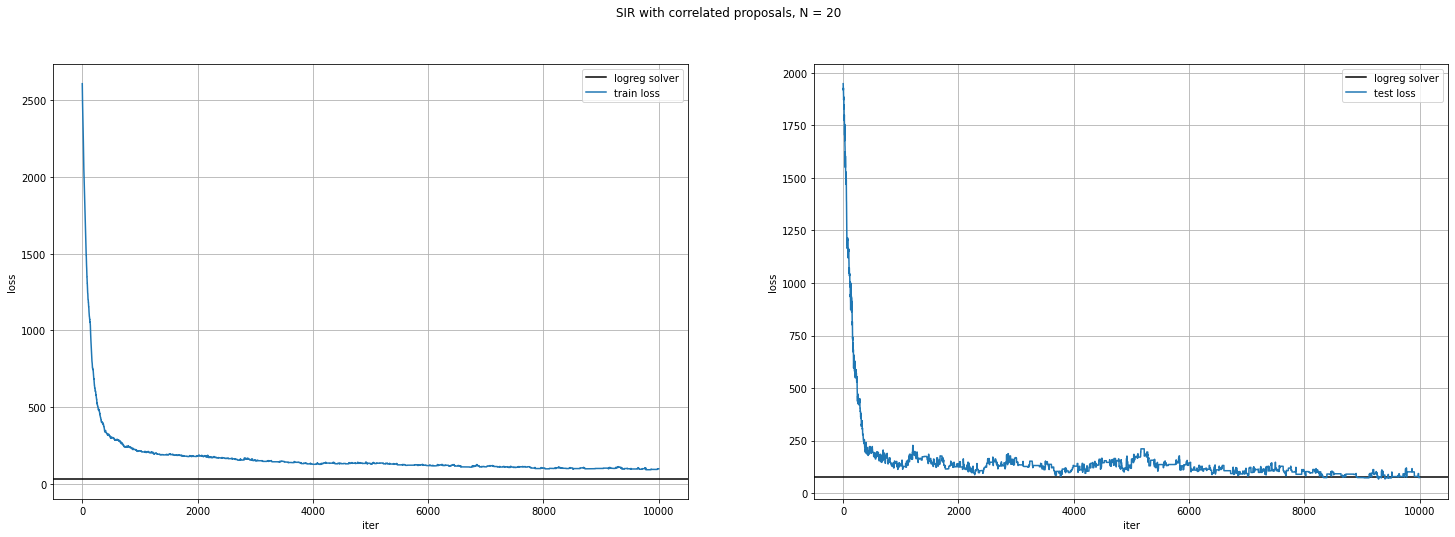

In [43]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [45]:
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
dim = X_train.shape[1]
proposal = init_independent_normal(scale_proposal, dim, device)
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
n_steps = 10000
N = 10
batch_size = 1
start = proposal.sample([batch_size])
#start = w_clf

In [46]:
history = sir_independent_dynamics(start, 
                                   target,
                                   proposal, 
                                   n_steps, 
                                   N)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

1505.900513, Test loss 1840.162354
Iter: 9679, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9680, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9681, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9682, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9683, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9684, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9685, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9686, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9687, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9688, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9689, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9690, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9691, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9692, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9693, Training loss: 1505.900513, Test loss 1840.162354
Iter: 9694, Training loss: 1505.900

In [47]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.496551724137931
0.4444444444444444


In [48]:
from sklearn.preprocessing import StandardScaler

In [49]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaler = torch.FloatTensor(scaler.transform(X_train))
# X_test_scaler = torch.FloatTensor(scaler.transform(X_test))
# X_train_small_scaler = X_train_scaler[:, :-1]
# X_test_small_scaler = X_test_scaler[:, :-1]
X_train_small_scaler = X_train_small
X_test_small_scaler = X_test_small
X_test_scaler = X_test
X_train_scaler = X_train

In [50]:
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small_scaler, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train_scaler, y_train).item()
    test_loss_clf = target.func(w_clf, X_test_scaler, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

max_iter = 1, train_loss = 98.31674194335938, test_loss = 52.18492889404297
max_iter = 2, train_loss = 97.22148132324219, test_loss = 53.89168930053711
max_iter = 3, train_loss = 95.53587341308594, test_loss = 56.150115966796875
max_iter = 4, train_loss = 94.13980865478516, test_loss = 59.76487350463867
max_iter = 5, train_loss = 92.92514038085938, test_loss = 58.46730041503906
max_iter = 6, train_loss = 91.28996276855469, test_loss = 56.03534698486328
max_iter = 7, train_loss = 90.2677001953125, test_loss = 56.457576751708984
max_iter = 8, train_loss = 89.03186798095703, test_loss = 55.725399017333984
max_iter = 9, train_loss = 87.65279388427734, test_loss = 56.919586181640625
max_iter = 10, train_loss = 86.727783203125, test_loss = 56.00035095214844
max_iter = 11, train_loss = 85.35400390625, test_loss = 52.73145294189453
max_iter = 12, train_loss = 84.35968780517578, test_loss = 50.84765625
max_iter = 13, train_loss = 83.85661315917969, test_loss = 46.50453567504883
max_iter = 14, t

In [51]:
print(clf.score(X_train_small_scaler, y_train))
print(clf.score(X_test_small_scaler, y_test))

0.9310344827586207
0.746031746031746


In [52]:
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
proposal = init_independent_normal(scale_proposal, dim, device)

n_steps = 10000
batch_size = 1
c = 0.01
N = 20
alpha = (1 - c/dim)**0.5
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
start = proposal.sample([batch_size])
#start = torch.zeros((1, dim))
#start = w_clf
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train_scaler,
                          y = y_train)

history = sir_correlated_dynamics(start, 
                                  target,
                                  proposal, 
                                  n_steps, 
                                  N, 
                                  alpha)
loss_train, loss_test = calculate_losses(history, target.func, 
                                         X_train_scaler, X_test_scaler, y_train, y_test)

ter: 9659, Training loss: 98.467018, Test loss 78.860786
Iter: 9660, Training loss: 98.467018, Test loss 78.860786
Iter: 9661, Training loss: 98.467018, Test loss 78.860786
Iter: 9662, Training loss: 98.467018, Test loss 78.860786
Iter: 9663, Training loss: 94.607300, Test loss 78.789742
Iter: 9664, Training loss: 94.607300, Test loss 78.789742
Iter: 9665, Training loss: 94.607300, Test loss 78.789742
Iter: 9666, Training loss: 94.607300, Test loss 78.789742
Iter: 9667, Training loss: 94.607300, Test loss 78.789742
Iter: 9668, Training loss: 94.607300, Test loss 78.789742
Iter: 9669, Training loss: 94.607300, Test loss 78.789742
Iter: 9670, Training loss: 94.607300, Test loss 78.789742
Iter: 9671, Training loss: 94.607300, Test loss 78.789742
Iter: 9672, Training loss: 94.607300, Test loss 78.789742
Iter: 9673, Training loss: 94.607300, Test loss 78.789742
Iter: 9674, Training loss: 94.607300, Test loss 78.789742
Iter: 9675, Training loss: 94.607300, Test loss 78.789742
Iter: 9676, Tra

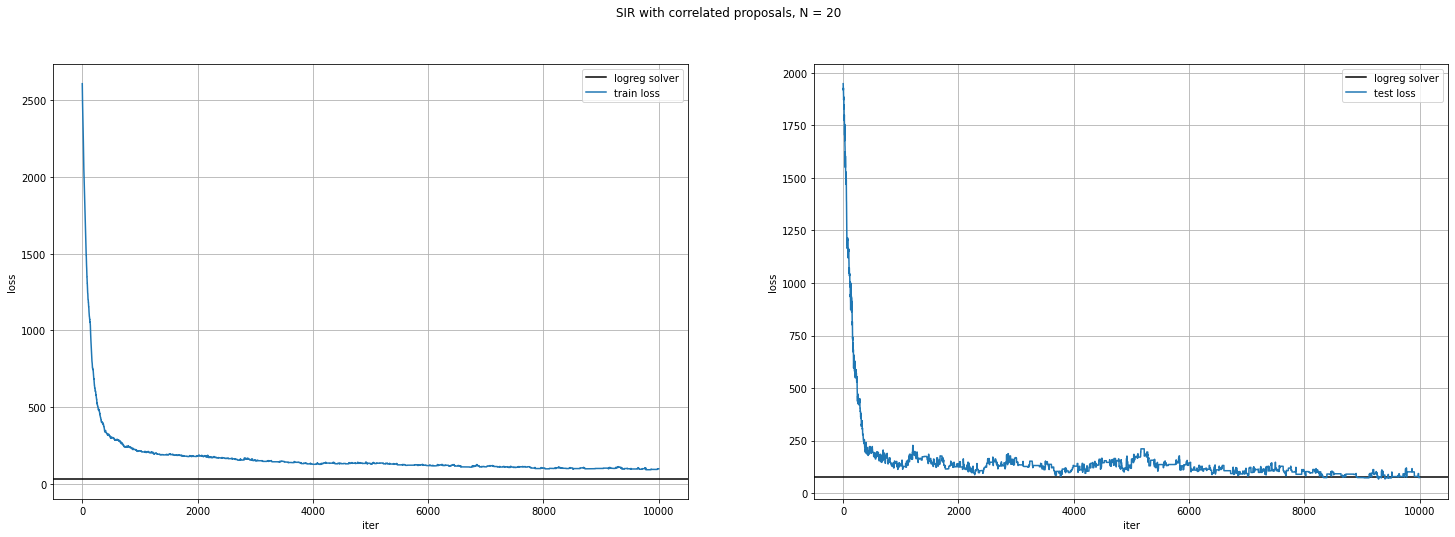

In [53]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'SIR with сorrelated proposals, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [54]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small_scaler, y_train))
print(clf.score(X_test_small_scaler, y_test))

0.7103448275862069
0.6507936507936508


# AIS

In [55]:
from sklearn.linear_model import LogisticRegression
num_iter = np.arange(100) + 1
l2_coef = 0.5
target = BinaryLogisticLoss(l2_coef)
target.log_prob = partial(target.log_prob_args, 
                          X = X_train,
                          y = y_train)
for max_iter in num_iter:
    clf = LogisticRegression(random_state=42,
                             tol=1e-7,
                             max_iter = max_iter,
                             C = 1.).fit(X_train_small, y_train)
    w_clf = torch.FloatTensor(np.concatenate((clf.coef_, clf.intercept_.reshape(1, 1)), axis=1))
    train_loss_clf = target.func(w_clf, X_train, y_train).item()
    test_loss_clf = target.func(w_clf, X_test, y_test).item()
    print(f"max_iter = {max_iter}, train_loss = {train_loss_clf}, test_loss = {test_loss_clf}")

max_iter = 1, train_loss = 98.31674194335938, test_loss = 52.18492889404297
max_iter = 2, train_loss = 97.22148132324219, test_loss = 53.89168930053711
max_iter = 3, train_loss = 95.53587341308594, test_loss = 56.150115966796875
max_iter = 4, train_loss = 94.13980865478516, test_loss = 59.76487350463867
max_iter = 5, train_loss = 92.92514038085938, test_loss = 58.46730041503906
max_iter = 6, train_loss = 91.28996276855469, test_loss = 56.03534698486328
max_iter = 7, train_loss = 90.2677001953125, test_loss = 56.457576751708984
max_iter = 8, train_loss = 89.03186798095703, test_loss = 55.725399017333984
max_iter = 9, train_loss = 87.65279388427734, test_loss = 56.919586181640625
max_iter = 10, train_loss = 86.727783203125, test_loss = 56.00035095214844
max_iter = 11, train_loss = 85.35400390625, test_loss = 52.73145294189453
max_iter = 12, train_loss = 84.35968780517578, test_loss = 50.84765625
max_iter = 13, train_loss = 83.85661315917969, test_loss = 46.50453567504883
max_iter = 14, t

In [56]:
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.9310344827586207
0.746031746031746


In [63]:
n_steps = 1000
grad_step = 1e-6
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
#start = w_clf
#start = torch.zeros((1, dim))
scale_proposal = 0.1
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)
start = proposal.sample([batch_size])
history = ais_vanilla_dynamics(start, 
                               target.log_prob,
                               proposal, 
                               n_steps, 
                               grad_step, 
                               eps_scale,
                               N, 
                               betas)
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

0, Training loss: 56.780552, Test loss 47.691040
Iter: 651, Training loss: 56.485325, Test loss 48.862572
Iter: 652, Training loss: 56.525406, Test loss 51.749790
Iter: 653, Training loss: 57.405891, Test loss 53.801414
Iter: 654, Training loss: 57.308689, Test loss 51.016144
Iter: 655, Training loss: 56.951660, Test loss 52.565536
Iter: 656, Training loss: 57.268940, Test loss 49.561085
Iter: 657, Training loss: 56.987774, Test loss 46.324623
Iter: 658, Training loss: 56.453979, Test loss 50.107018
Iter: 659, Training loss: 57.360214, Test loss 53.595490
Iter: 660, Training loss: 57.139832, Test loss 51.727108
Iter: 661, Training loss: 56.836300, Test loss 49.978672
Iter: 662, Training loss: 56.590141, Test loss 50.497948
Iter: 663, Training loss: 56.477512, Test loss 50.543419
Iter: 664, Training loss: 56.598988, Test loss 48.578487
Iter: 665, Training loss: 56.800278, Test loss 50.055122
Iter: 666, Training loss: 57.114788, Test loss 49.636169
Iter: 667, Training loss: 56.223408, Te

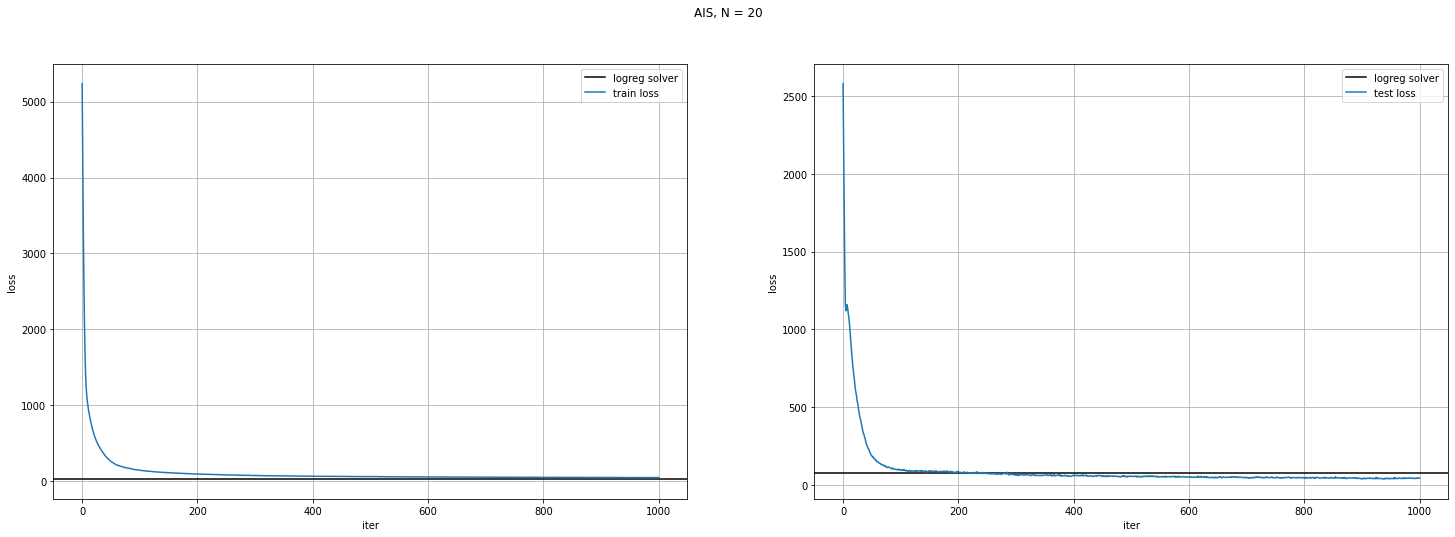

In [64]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'AIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [65]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.8551724137931035
0.6349206349206349


In [66]:
n_steps = 100
grad_step = 1e-6 #5e-6
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
rhos = np.linspace(.8, 1., T)[::-1]

#start = torch.zeros((1, len(betas), dim))
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)
#start = proposal.sample([batch_size, len(betas)])
#start = torch.zeros((1, len(betas), dim))
start = w_clf.unsqueeze(1).repeat(1, len(betas), 1)
start.requires_grad_(True)
history = ais_dynamics(start, target.log_prob, proposal, n_steps, grad_step, eps_scale, N, betas, rhos)

100%|██████████| 100/100 [00:04<00:00, 24.72it/s]


In [67]:
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

Iter: 0, Training loss: 30.914835, Test loss 78.047920
Iter: 1, Training loss: 30.914835, Test loss 78.047920
Iter: 2, Training loss: 30.914835, Test loss 78.047920
Iter: 3, Training loss: 30.914835, Test loss 78.047920
Iter: 4, Training loss: 30.914835, Test loss 78.047920
Iter: 5, Training loss: 30.914835, Test loss 78.047920
Iter: 6, Training loss: 30.914835, Test loss 78.047920
Iter: 7, Training loss: 30.914835, Test loss 78.047920
Iter: 8, Training loss: 30.914835, Test loss 78.047920
Iter: 9, Training loss: 30.914835, Test loss 78.047920
Iter: 10, Training loss: 30.914835, Test loss 78.047920
Iter: 11, Training loss: 30.914835, Test loss 78.047920
Iter: 12, Training loss: 30.914835, Test loss 78.047920
Iter: 13, Training loss: 30.914835, Test loss 78.047920
Iter: 14, Training loss: 30.914835, Test loss 78.047920
Iter: 15, Training loss: 30.914835, Test loss 78.047920
Iter: 16, Training loss: 30.914835, Test loss 78.047920
Iter: 17, Training loss: 30.914835, Test loss 78.047920
It

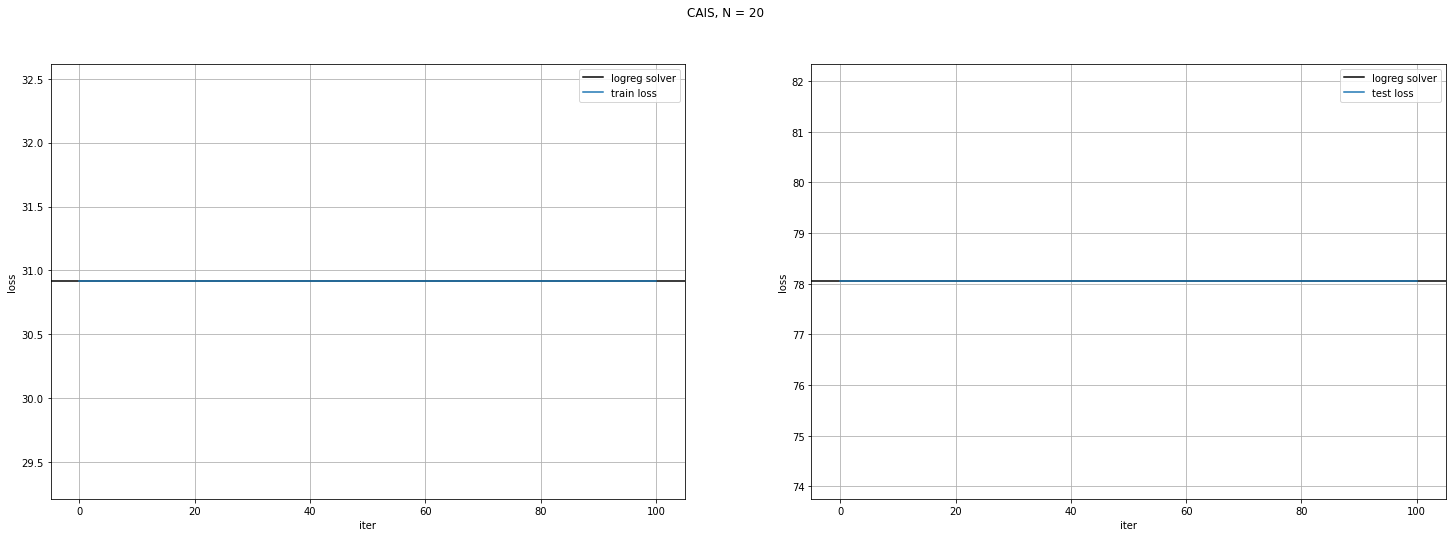

In [68]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'CAIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [69]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.9310344827586207
0.746031746031746


In [94]:
n_steps = 1000
grad_step = 1e-6
eps_scale = (2*grad_step)**0.5
N = 20
T = 10
betas = np.linspace(1., 0., T)
rhos = np.linspace(.8, 1., T)[::-1]

#start = torch.zeros((1, len(betas), dim))
device = 'cpu'
scale_proposal = 0.1
random_seed = 42
batch_size = 1
proposal = init_independent_normal(scale_proposal, dim, device)

start = proposal.sample([batch_size, len(betas)])
#start = torch.zeros((1, len(betas), dim))

start.requires_grad_(True)
history = ais_dynamics(start, target.log_prob, proposal, n_steps, grad_step, eps_scale, N, betas, rhos)

100%|██████████| 1000/1000 [00:39<00:00, 25.11it/s]


In [95]:
loss_train, loss_test = calculate_losses(history, target.func, X_train, X_test, y_train, y_test)

er: 662, Training loss: 991.102661, Test loss 520.529968
Iter: 663, Training loss: 991.102661, Test loss 520.529968
Iter: 664, Training loss: 991.102661, Test loss 520.529968
Iter: 665, Training loss: 991.102661, Test loss 520.529968
Iter: 666, Training loss: 991.102661, Test loss 520.529968
Iter: 667, Training loss: 991.102661, Test loss 520.529968
Iter: 668, Training loss: 991.102661, Test loss 520.529968
Iter: 669, Training loss: 991.102661, Test loss 520.529968
Iter: 670, Training loss: 991.102661, Test loss 520.529968
Iter: 671, Training loss: 991.102661, Test loss 520.529968
Iter: 672, Training loss: 991.102661, Test loss 520.529968
Iter: 673, Training loss: 991.102661, Test loss 520.529968
Iter: 674, Training loss: 991.102661, Test loss 520.529968
Iter: 675, Training loss: 991.102661, Test loss 520.529968
Iter: 676, Training loss: 991.102661, Test loss 520.529968
Iter: 677, Training loss: 991.102661, Test loss 520.529968
Iter: 678, Training loss: 991.102661, Test loss 520.529968

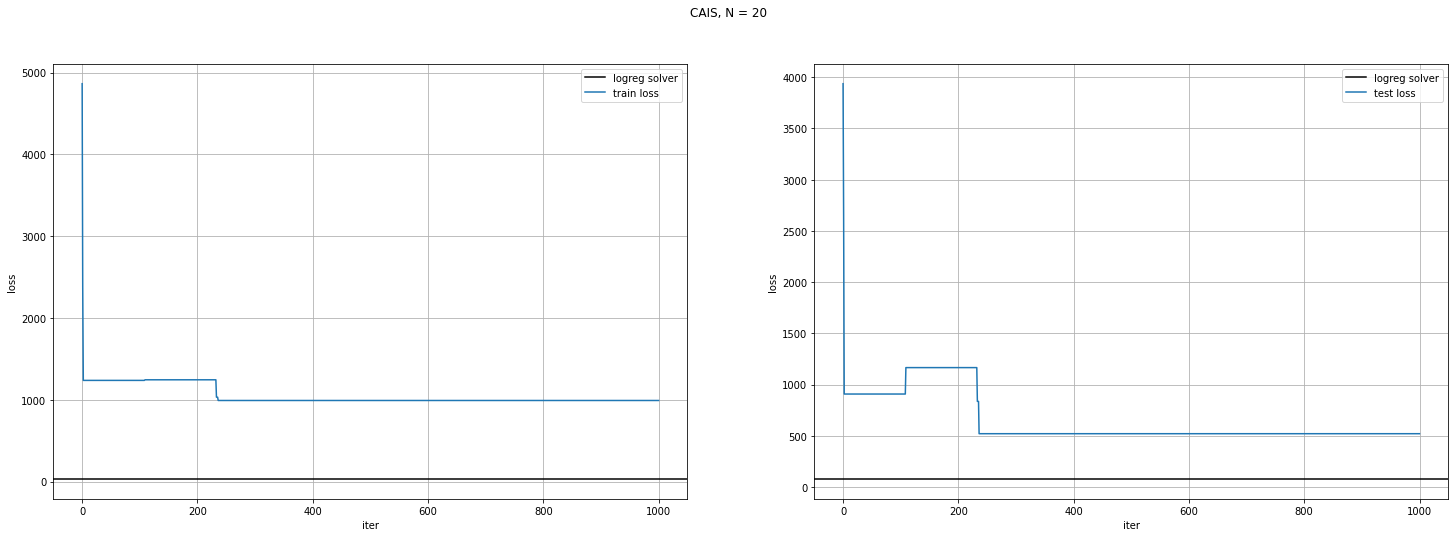

In [96]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(25, 8))
name = f'CAIS, N = {N}'
fig.suptitle(name)

axs[0].axhline(train_loss_clf, label='logreg solver', color='black')
axs[0].set_xlabel('iter')
axs[0].set_ylabel('loss')
axs[0].plot(np.arange(len(loss_train)), loss_train, label = 'train loss')

axs[1].axhline(test_loss_clf, label='logreg solver', color='black')
axs[1].set_xlabel('iter')
axs[1].set_ylabel('loss')
axs[1].plot(np.arange(len(loss_test)), loss_test, label = 'test loss')


for ax in axs:
    ax.grid()
    ax.legend()

plt.show()

In [97]:
last_w = history[-1].numpy()
clf.coef_ = last_w[:, :-1]
clf.intercept_ = last_w[:, -1]
print(clf.score(X_train_small, y_train))
print(clf.score(X_test_small, y_test))

0.496551724137931
0.4444444444444444
